# Examen práctico 
## Parcial 3 Laboratorio de Aprendizaje Estadístico
Diego Lozoya Morales | 745345

# Paqueterías

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [2]:
def calibracion(probabilidades, y_test):
    df_calibracion = pd.DataFrame({
        'probabilidades':probabilidades,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['probabilidades'], q=15, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.probabilidades, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.probabilidades, grouped.probabilidades, label="Real", marker="o", color=colors[1])
    plt.xlabel("Probabilidad")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def histograma(probabilidades, y_test):
     df = pd.DataFrame({
     'real': y_test,
     'probabilidades': probabilidades
     })

     plt.figure()
     plt.hist(df[df.real == 1]['probabilidades'], density=True, color=colors[0], alpha=0.5, label = '1')
     plt.hist(df[df.real == 0]['probabilidades'], density=True, color=colors[1], alpha=0.5, label = '0')
     plt.title(f'Histograma de probabilidades')
     plt.xlabel("Probabilidad")
     plt.ylabel(" ")
     plt.legend()
     plt.show()

def roc(probabilidades, y_test):
     fpr, fnp, scores = roc_curve(y_score=probabilidades, y_true=y_test)
     plt.figure()
     plt.plot(fpr, fnp, color=colors[0], lw=2)
     plt.plot([0, 1], [0, 1], color=colors[1], linestyle='--', lw=2, label='Clasificador aleatorio')
     plt.xlabel('1 - Specificity')
     plt.ylabel('Sensitivity')
     plt.title('ROC curve')
     plt.legend()
     plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
          plt.text(value - 0.001, index, f"{value:.4f}", va="center", ha='right')
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def depth2Tree(X_train, y_train):
     tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

     plt.figure()
     plot_tree(tree, feature_names=X_train.keys(), filled=True, rounded=True, proportion=True, class_names=True)
     plt.show()

def decision_tree(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('tree', DecisionTreeClassifier(random_state=42))
     ])

     params = {
          'tree__max_depth': list(range(1, 10)),
          'tree__max_features': ['log2', 'sqrt', 10, 11, 12],
          'tree__min_samples_split': list(range(2, 10)),
          'tree__min_samples_leaf': list(range(5, 15))
     }
     tree_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="roc_auc")
     tree_grid.fit(X_train, y_train)

     best_model = tree_grid.best_estimator_.named_steps['tree']
     probabilidades = best_model.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     return print(f'Mejor modelo: {tree_grid.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

def random_forest(X_train, X_test, y_train, y_test):
     pipeline = Pipeline([
          ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
     ])

     params = {
          'rf__n_estimators': [400, 450, 500, 550, 600],
          'rf__max_depth': list(range(10, 15)),
          'rf__max_features': ['log2', 'sqrt', 10, 12],
     }
     rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring="roc_auc")
     rf_grid.fit(X_train, y_train)

     best_model = rf_grid.best_estimator_.named_steps['rf']
     probabilidades = best_model.predict_proba(X_test)[:, 1]
     auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
     gini = 2*auc - 1

     calibracion(probabilidades, y_test)
     roc(probabilidades, y_test)
     histograma(probabilidades, y_test)

     features = X_train.columns
     importances = best_model.feature_importances_

     importance(features, importances, 5, 'Feature Importance')

     return print(f'Mejor modelo: {rf_grid.best_params_}\n\nAUC: {auc:.4f}\nGini: {gini:.4f}')

def xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(n_estimators=10000, max_depth=5, learning_rate=0.1, reg_lambda=0.1, 
                          subsample=0.5, colsample_bytree=0.8, tree_method='hist', gamma=0.1
                          )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=20)

    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    eval_model = model.evals_result()
    train_loss = eval_model['validation_0']['logloss']
    test_loss = eval_model['validation_1']['logloss']

    loss(train_loss, test_loss)

    importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
    importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

    # Separar nombres y valores
    features_weight = list(importancia_weight_dict.keys())
    valores_weight = list(importancia_weight_dict.values())

    features_gain = list(importancia_gain_dict.keys())
    valores_gain = list(importancia_gain_dict.values())

    importance(features_weight, valores_weight, 5, 'weight')
    importance(features_gain, valores_gain, 5, 'gain')

    return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

def lightgbm(X_train, X_test, y_train, y_test):
    model = LGBMClassifier(num_iterations=10000, num_leaves=10, learning_rate=0.1, max_depth=6, lambda_l2=0.1, 
                           subsample=0.5, feature_fraction=0.8, verbosity=-1, metric=['auc', 'binary_logloss']
                           )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              callbacks=[early_stopping(20), log_evaluation(100)])
    
    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    train_loss = model.evals_result_['training']['binary_logloss']
    test_loss = model.evals_result_['valid_1']['binary_logloss']

    loss(train_loss, test_loss)

    importancia_split = model.booster_.feature_importance(importance_type='split')
    importancia_gain = model.booster_.feature_importance(importance_type='gain')
    features = model.booster_.feature_name()

    importance(features, importancia_split, 5, 'split')
    importance(features, importancia_gain, 5, 'gain')

    return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

def catboost():
    data = pd.read_csv('Data/hr_role.csv')
    data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})
    target = 'Attrition'
    y = data[target]
    X = data.copy().drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')
    
    model = CatBoostClassifier(iterations=10000, depth=5, learning_rate=0.1, subsample=0.5, rsm=0.8, eval_metric='AUC', 
                               l2_leaf_reg=0.1, random_strength=5, verbose=100, early_stopping_rounds=20    
                               )
    model.fit(X_train, y_train, cat_features=cat_cols, eval_set=[(X_test, y_test)])

    probabilidades = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    gini = 2*auc - 1

    calibracion(probabilidades, y_test)
    roc(probabilidades, y_test)
    histograma(probabilidades, y_test)

    importancia = model.get_feature_importance(type='PredictionValuesChange')
    features = model.feature_names_

    importance(features, importancia, 5, 'PredictionValuesChange')

    return print(f'AUC: {auc:.4f}\nGini: {gini:.4f}')

# Data

In [3]:
data = pd.read_csv('Data/hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## Variable dependiente

In [4]:
target = 'Attrition'
y = data[target]

# Feature engineering

## Dummies

In [5]:
data = pd.get_dummies(data)
data.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,5993,...,False,False,True,False,False,False,True,True,False,True
1,49,0,279,8,1,3,61,2,2,5130,...,False,True,False,False,False,True,False,True,True,False
2,37,1,1373,2,2,4,92,2,1,2090,...,False,False,False,False,False,False,True,True,False,True
3,33,0,1392,3,4,4,56,3,1,2909,...,False,True,False,False,False,True,False,True,False,True
4,27,0,591,2,1,1,40,3,1,3468,...,False,False,False,False,False,True,False,True,True,False


## Transformaciones

In [6]:
data['Age_2'] = data['Age']**2
data['HourlyRate_2'] = data['HourlyRate']**2

## Nuevas variables

In [7]:
data['Rate/Age'] = data['HourlyRate'] / data['Age']

# Preparación de datos

## Cross validation

In [8]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Árbol de decisión

## Depth 2

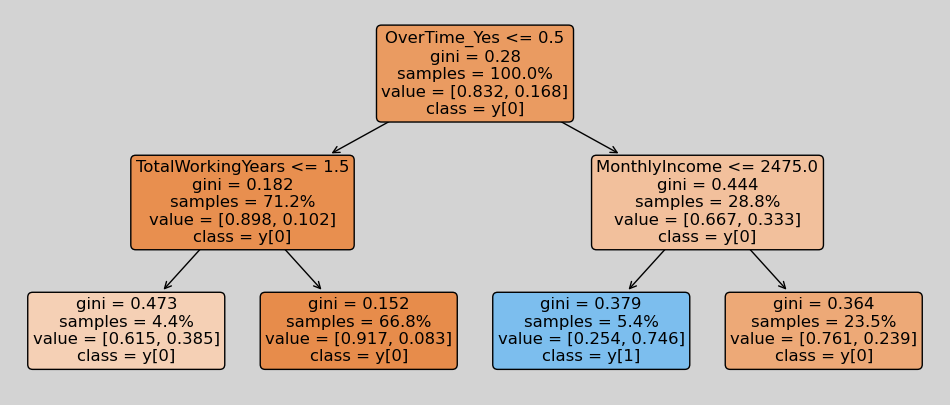

In [9]:
depth2Tree(X_train, y_train)

El árbol con profundidad 2 nos ayuda a visualizar cuales son las variables más decisivas del árblos, pues son las que se usan de manera inicial, para comenzar a asegmentar a los datos. El primer criterio que toma en cuenta es si la persona en cuatión trabaja horas extras o no. Despues en los subárboles toma los criterios de años de trabajo con umbral de 1.5 años e ingreso mensual con umbral de \$2,475.00. Con base en estos criterios se puede ver un poco cuales son las características mas influyentes en la attrition. Si se trabajan horas extras y se tiene un salario bajo, es muy probable que la persona no continúe trabajando en la empresa. Por otro lado se puede ver que el grupo de personas que menos probabilidad tienen de abandonar la empresa son aquellos que no trabajan horas extras y que llevan 2 o más años trabajando en la empresa. 

## Mejor árbol

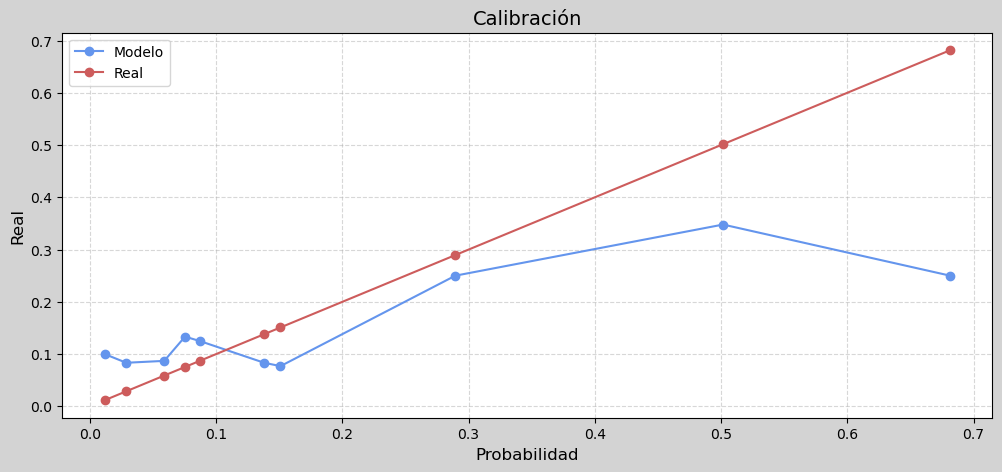

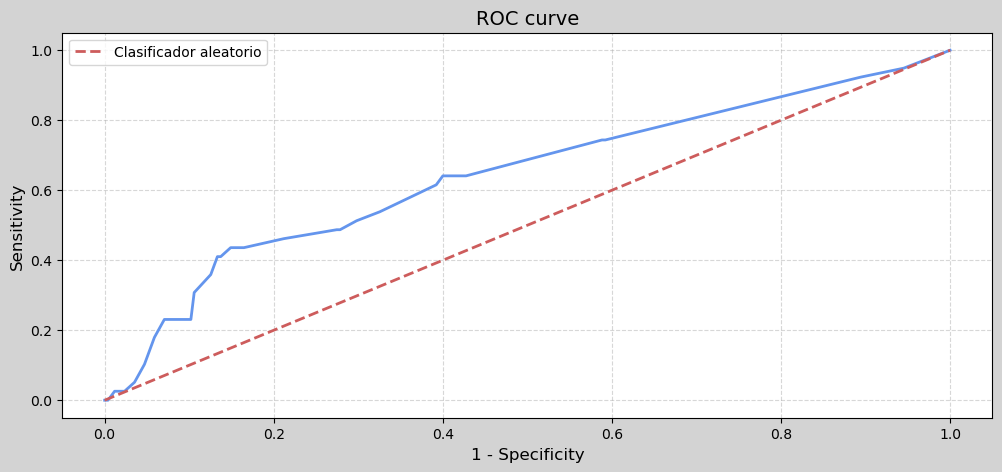

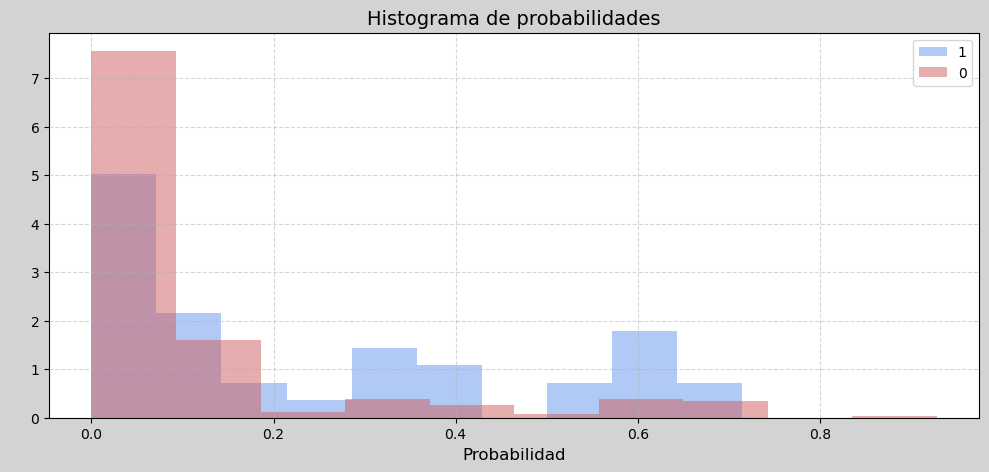

Mejor modelo: {'tree__max_depth': 6, 'tree__max_features': 11, 'tree__min_samples_leaf': 14, 'tree__min_samples_split': 2}

AUC: 0.6422
Gini: 0.2844


In [10]:
decision_tree(X_train, X_test, y_train, y_test)

# Random Forest

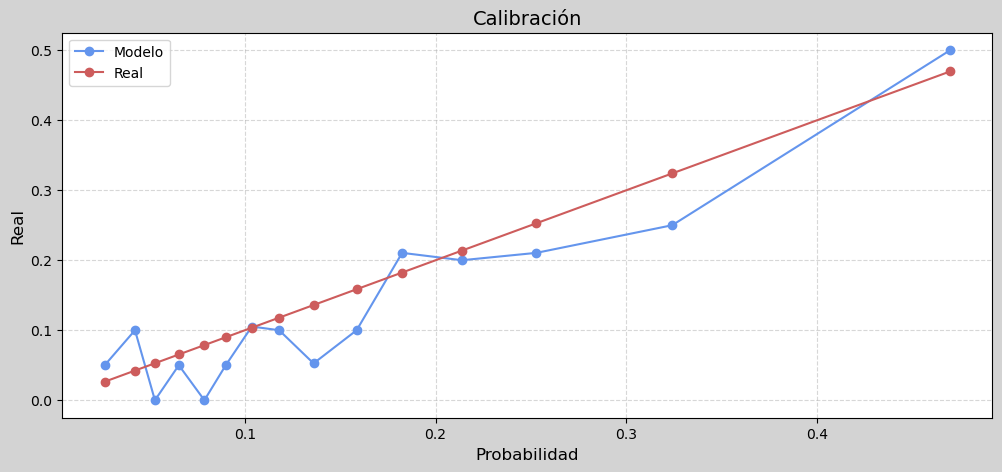

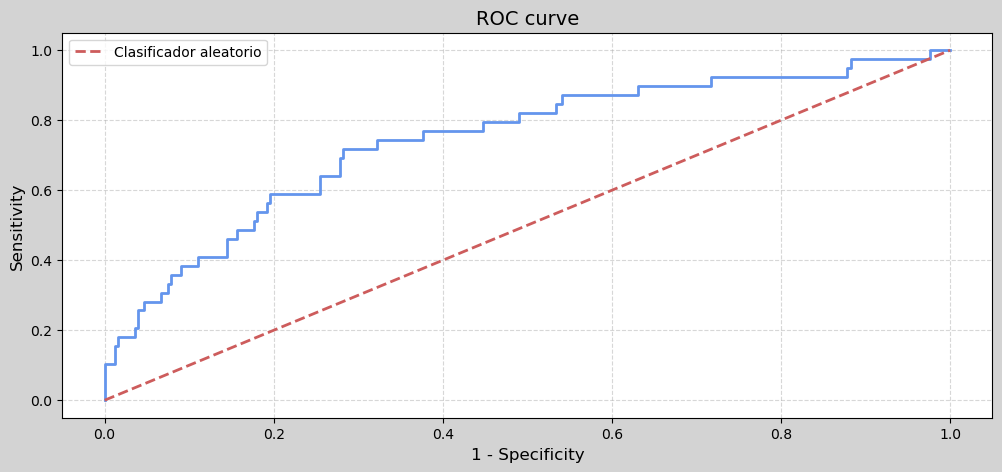

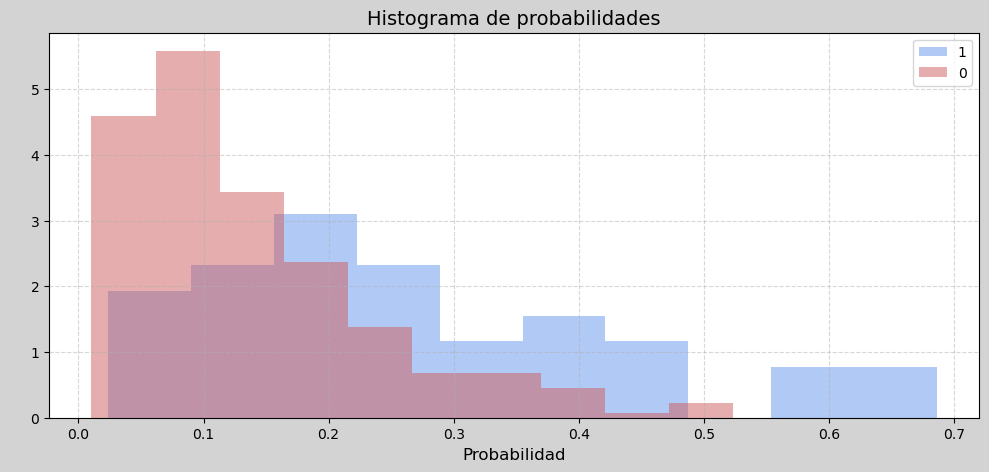

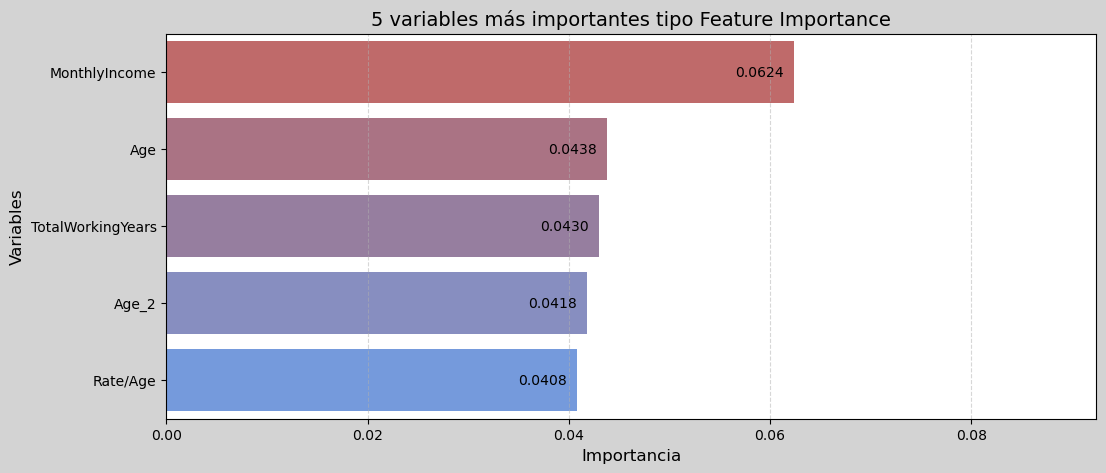

Mejor modelo: {'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__n_estimators': 550}

AUC: 0.7447
Gini: 0.4894


In [11]:
random_forest(X_train, X_test, y_train, y_test)

Tras haber realizado el Random Forest se puede ver que las variables más influyentes en la predicción de attrition son MonthlyIncome, Age, TotalWorkingYears, Age_2 y Rate/Age, estando todas excepto MontlyIncome bastante igualadas en su valor de importancia.

# XGBoost

[0]	validation_0-logloss:0.63873	validation_1-logloss:0.64183
[68]	validation_0-logloss:0.11548	validation_1-logloss:0.32990


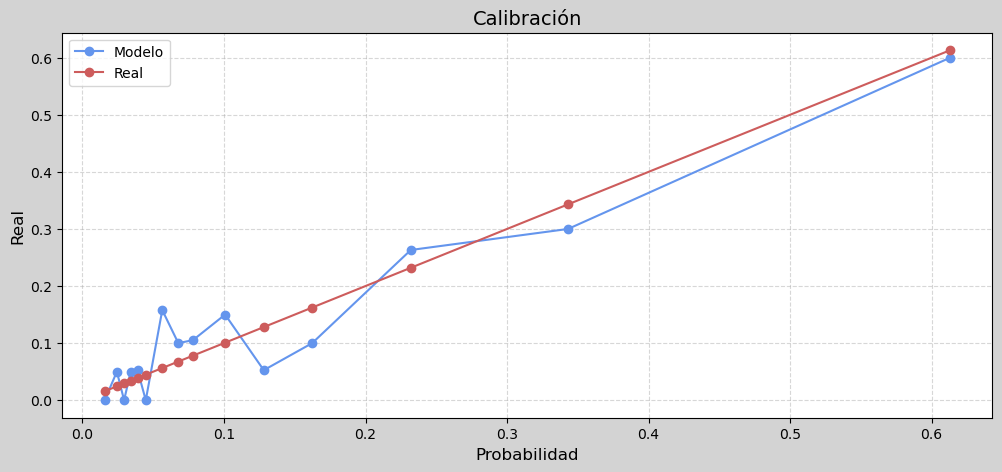

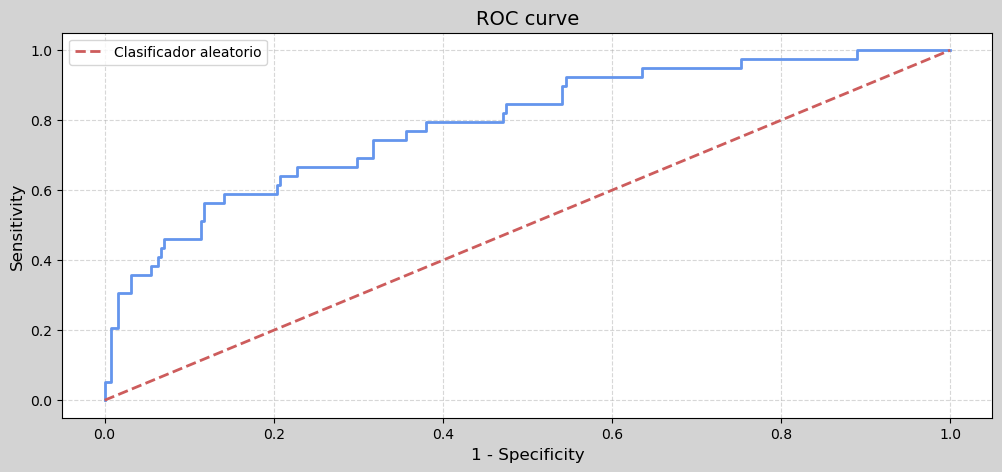

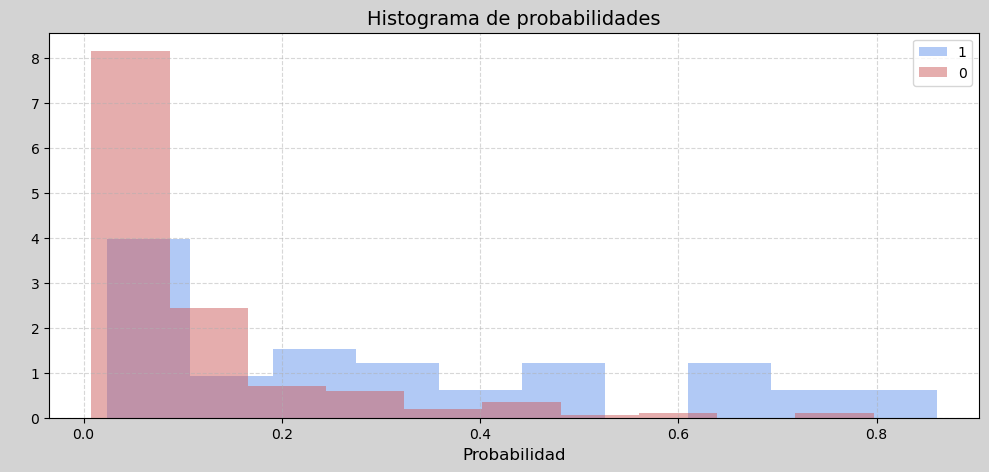

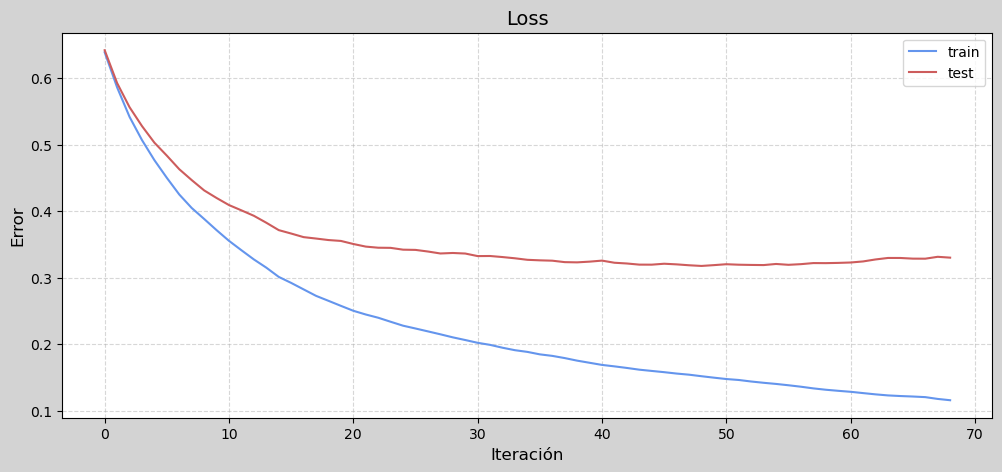

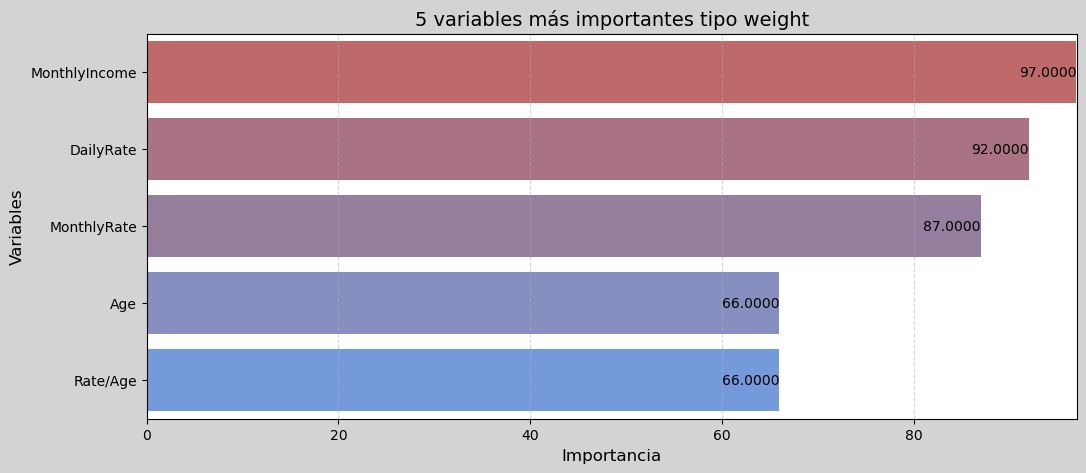

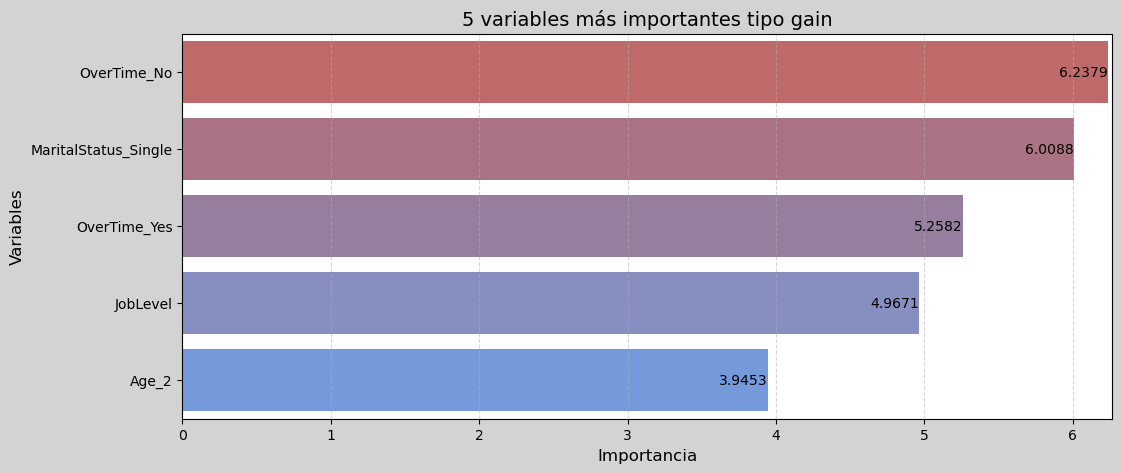

AUC: 0.7899
Gini: 0.5799


In [12]:
xgboost(X_train, X_test, y_train, y_test)

Para XGBoost las variables más utilizadas en el modelo fueron MonthlyIncome, DailyRate, MonthlyRate, Age y Rate/Age, en donde las primeras 3 mencionas uvieron valores más elevados, mientras que las últimas 2 fueron igual de utilizadas. Por otra parte las variables más útiles para la mejora de la función objetvo fueron OverTime_No, MaritalStatus_Single, OverTime_Yes, JobLevel y Age_2. Interesante ver que estan ambas opciones de OverTime, lo que refuerza lo explicado por el árbol de depth 2, trabajar horas extras o no es decisivo para la predicción de attrition. 

# LightGBM

Training until validation scores don't improve for 20 rounds
[100]	training's auc: 0.997371	training's binary_logloss: 0.117189	valid_1's auc: 0.772951	valid_1's binary_logloss: 0.322866
Early stopping, best iteration is:
[82]	training's auc: 0.994898	training's binary_logloss: 0.138668	valid_1's auc: 0.775465	valid_1's binary_logloss: 0.319636


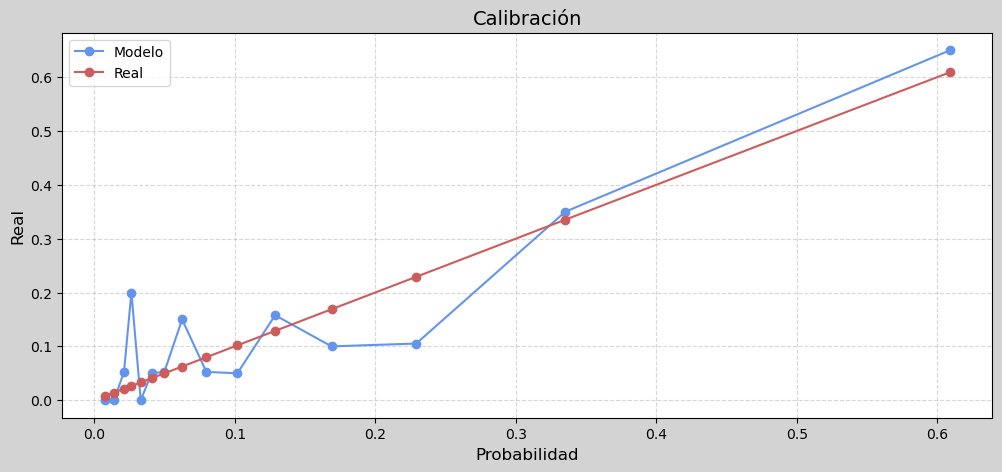

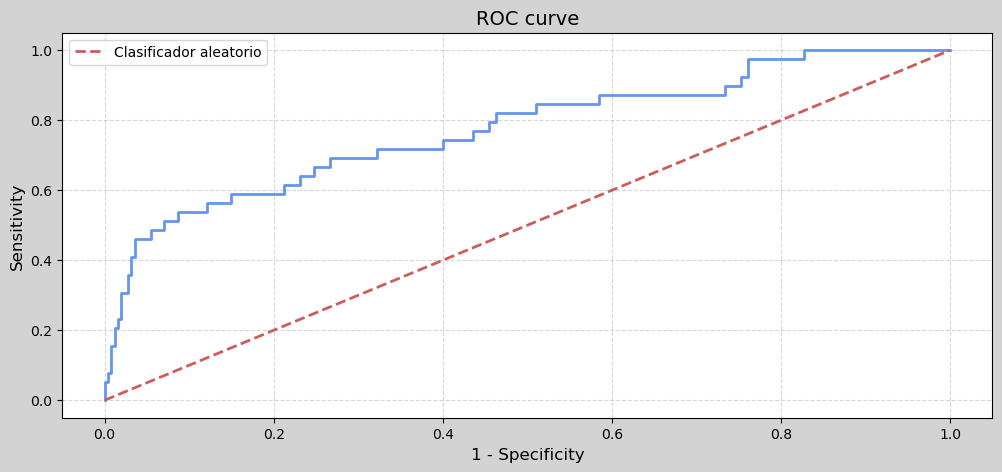

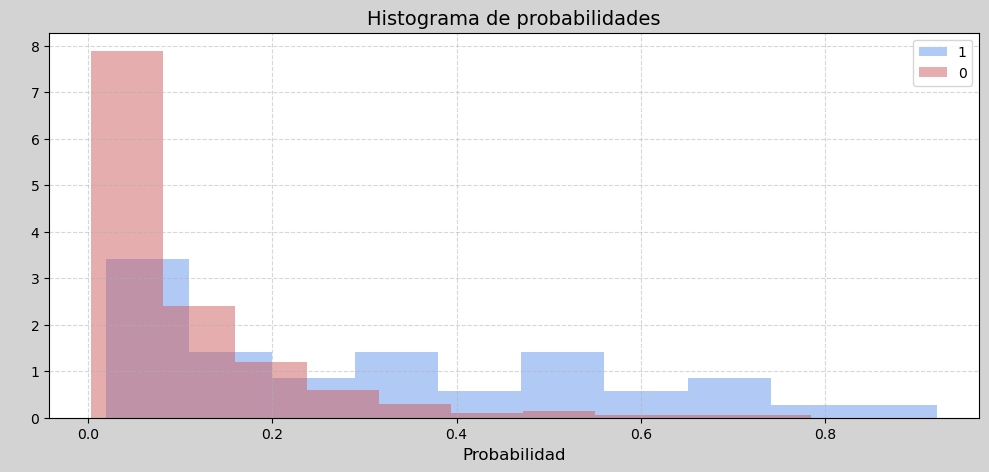

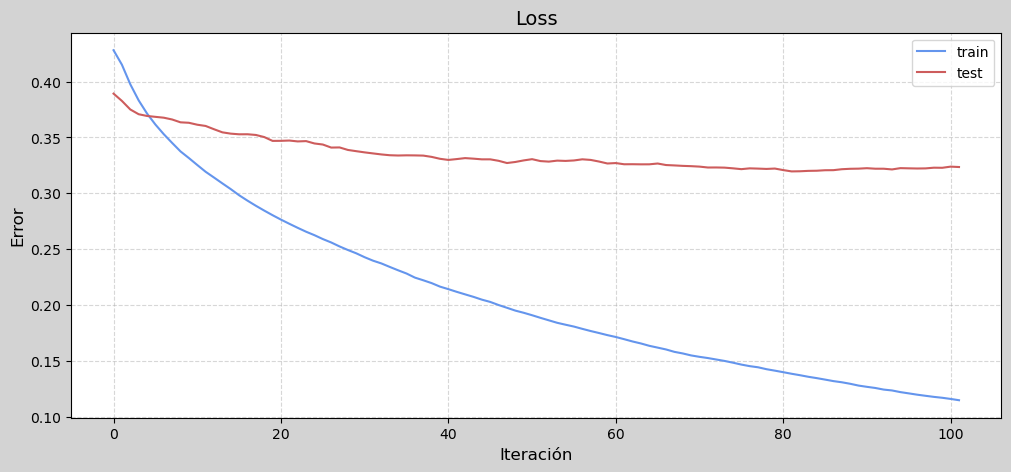

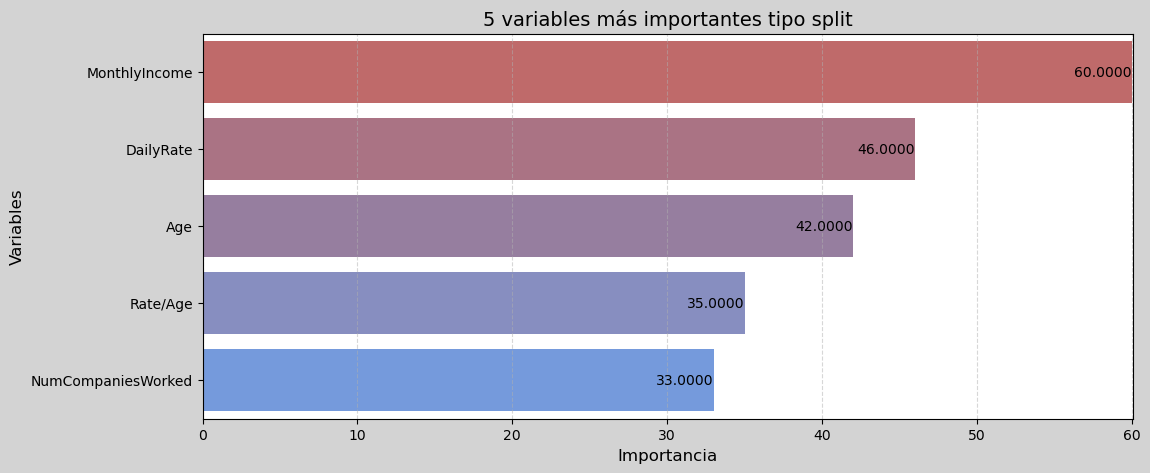

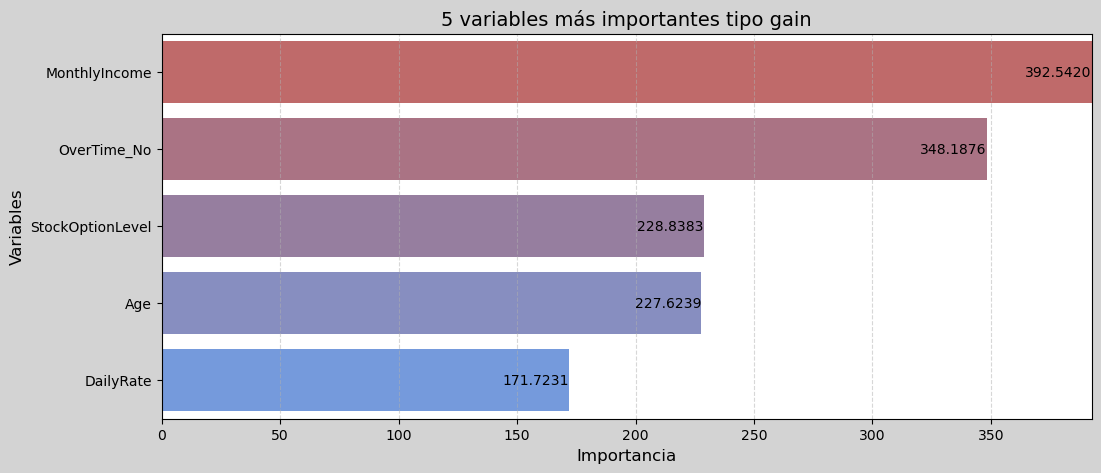

AUC: 0.7755
Gini: 0.5509


In [13]:
lightgbm(X_train, X_test, y_train, y_test)

En el modelo de lightGBM las variables más utilizadas fueron MonthlyIncome, DailyRate, Age, Rate/Age y NumCompaniesWorked, en donde MonthlyIncome muestra una superioridad muy notable. Sin embarego, las variables, más significativas para la reducción del error del modelo fueron MonthlyIncome, OverTime_No, StockOptionLevel, Age y DailyRate. De estas MontlyIncome y OverTime_No muestran una mucho mayor importancia.

# CatBoost

0:	test: 0.5896933	best: 0.5896933 (0)	total: 60.1ms	remaining: 10m
100:	test: 0.7369532	best: 0.7369532 (100)	total: 273ms	remaining: 26.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7563599799
bestIteration = 116

Shrink model to first 117 iterations.


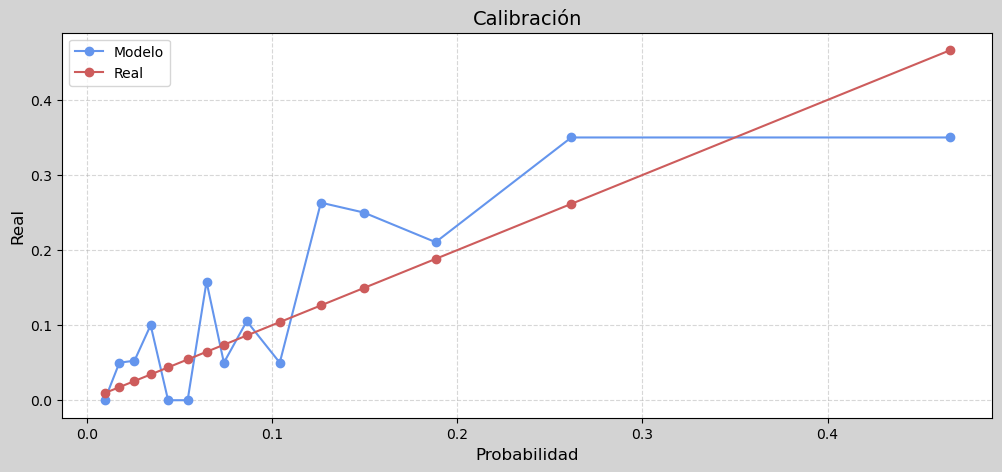

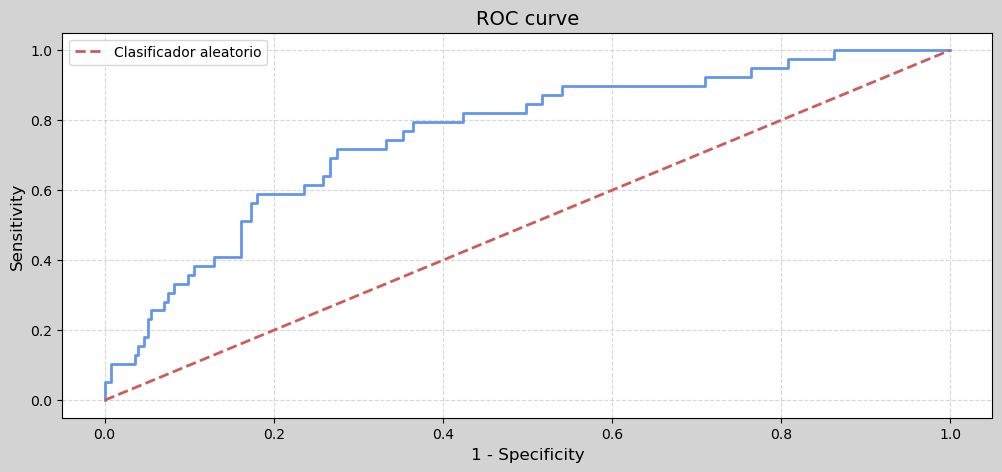

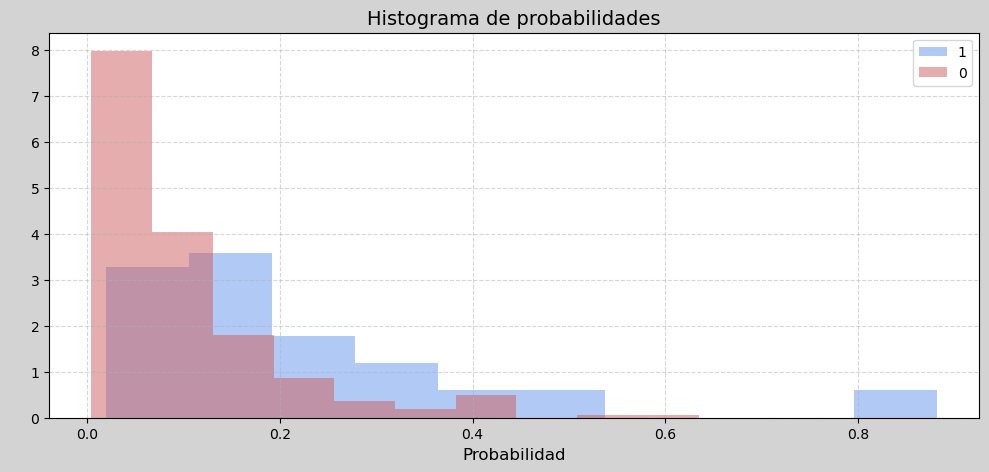

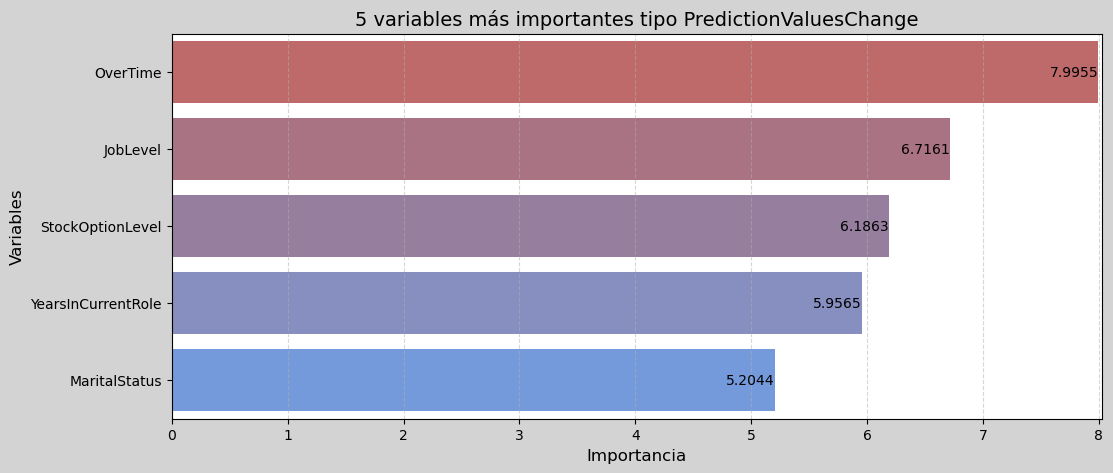

AUC: 0.7564
Gini: 0.5127


In [14]:
catboost()

CatBoost, usa su propio encoding para las variables categóricas, de modo que muestra variable que de por si no usan los demás modelos, pues para ellos fue necesaria la creación de variables dummies (One-Hot encoding), por ejemplo. Las variables más importantes fueron OverTime, JobLevel, StockOptionLevel, YearsInCurrentRole y MartialStatus, en donde se puede reforzar una vez más la visualización del árbol de profundidad 2, donde trabajar tiempo extra es decisivo. 

# Conlusiones generales

El dataset de este análisis, presenta diferentes datos de los trabajadores de una empresa. Con esto se trata de predecir Attrition, lo cual en el contexto del análisis de recursos humanos, hace referencia a la pérdida de empleados por razones como despido, renuncia, jubilación, etc. Ya que esta variable es binaria (Yes y No), se trata de un problema de clasificación. Como estos tipos de dato son string, se deben de convertir en booleanos (0 y 1) para que los modelos puedan utiliarlos para predecir. 

El mejor modelo fue XGBoost, el cual obtuvo un AUC de 0.7899 y un coeficiente de Gini de 0.5799. El valor de Gini, que mide la desigualdad en la distribución de las predicciones, refleja la capacidad del modelo para separar correctamente los casos positivos y negativos. Un Gini de 0.5799 indica que el modelo tiene un 57.99% de poder predictivo por encima del azar, lo que representa un desempeño sólido en términos de discriminación entre empleados que se quedan y los que presentan “Attrition”. 

En este modelo las variables más utilizadas son:

| **# Importancia** | **Variable**      | **Weight** |
|-------------------|-------------------|------------|
| 1                 | MonthlyIncome     | 97         |
| 2                 | DailyRate         | 92         |
| 3                 | MonthlyRate       | 87         |

Mientras que las variables que más han ayudado a mejor al modelo son:

| **# Importancia** | **Variable**         | **Gain** |
|-------------------|----------------------|----------|
| 1                 | OverTime_No          | 6.2379   |
| 2                 | MaritalStatus_Single | 6.0088   |
| 3                 | OverTime_Yes         | 5.2582   |

Estos valores, especialmente los de *gain*, refuerzan la idea inicial planteada por el árbol de depth 2; el factor más importante es si un trabajador trabaja horas extras o no. Por la naturaleza de la variable esta se divide en dummies, sin embargo, ambas opciones se escuentran en el top 3. Además se podría concluir que aquellas personas con estado civil "soltero" son muy buen elemento predictivo.